# Assignment 8 

### Task 

Download the [COCO](https://cocodataset.org/#home) dataset.

***Do not*** try to open `captions_train2017.json` with your usual editor. Use one that reads in portions of data, like `LTFViewer` on Windows or [UltraEdit](https://www.ultraedit.com/downloads/ultraedit-download/) for both Windows and the Mac (and read [this](https://www.ultraedit.com/support/tutorials-power-tips/ultraedit/large-file-handling.html) beforehand).

Train your model on COCO on your laptop and tell me what the upper limits of the possible are.



In [ ]:
# !pip install tensorflow

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.12.0'

In [3]:
import numpy as np

In [4]:
np.__version__

'1.23.0'

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
import os
import pickle
from PIL import Image
#from cache import cache

In [6]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
from pathlib import Path
from pycocotools.coco import COCO
dataDir=Path('train2017')
annFile = Path('annotations/person_keypoints_train2017.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds[-3:])
imgs

loading annotations into memory...
Done (t=8.73s)
creating index...
index created!


[{'license': 3,
  'file_name': '000000516168.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000516168.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-25 21:03:34',
  'flickr_url': 'http://farm3.staticflickr.com/2379/2293730995_e2381ffa38_z.jpg',
  'id': 516168},
 {'license': 4,
  'file_name': '000000547503.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000547503.jpg',
  'height': 375,
  'width': 500,
  'date_captured': '2013-11-25 21:20:21',
  'flickr_url': 'http://farm1.staticflickr.com/178/423174638_1c6245ee20_z.jpg',
  'id': 547503},
 {'license': 4,
  'file_name': '000000475546.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000475546.jpg',
  'height': 375,
  'width': 500,
  'date_captured': '2013-11-25 21:20:23',
  'flickr_url': 'http://farm1.staticflickr.com/167/423175046_6cd9d0205a_z.jpg',
  'id': 475546}]

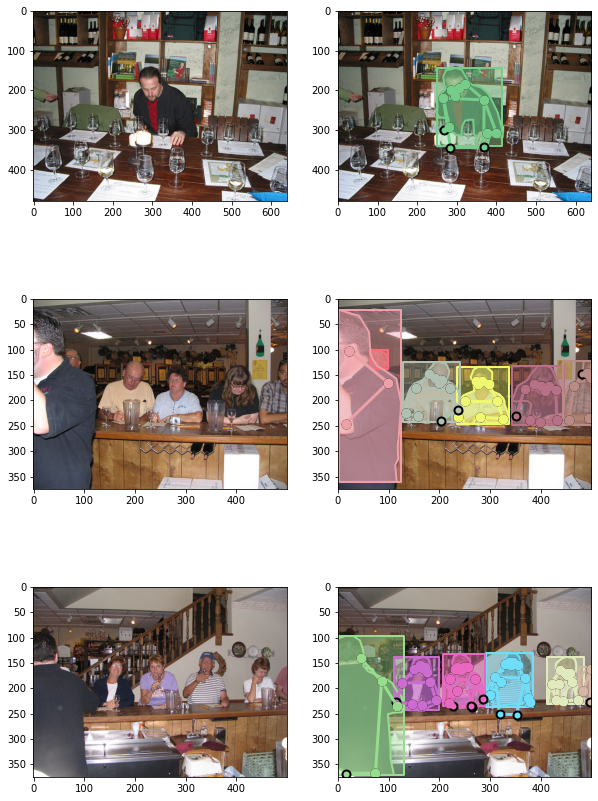

In [8]:
import skimage.io as io

_,axs = plt.subplots(len(imgs),2,figsize=(10,5 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = io.imread(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

How to show just the masks:

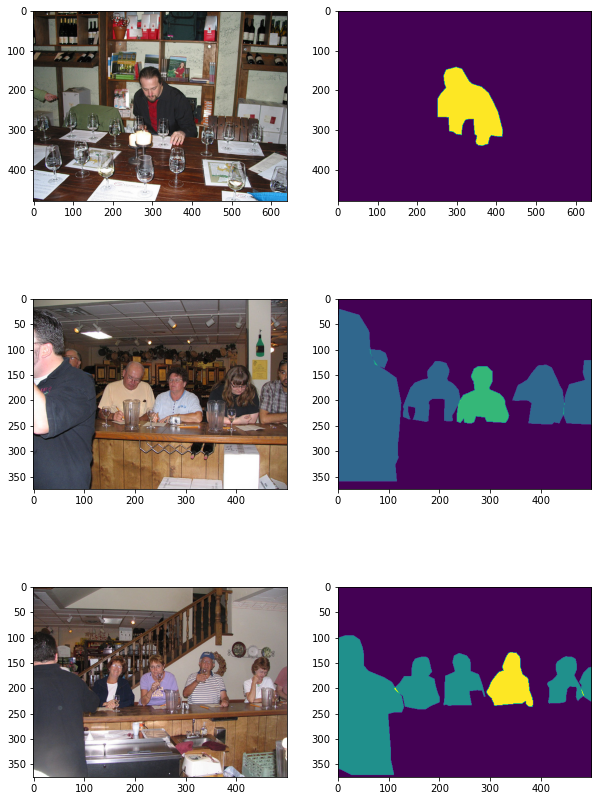

In [9]:
_,axs = plt.subplots(len(imgs),2,figsize=(10,5 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = io.imread(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    
    mask = coco.annToMask(anns[0])
    for i in range(len(anns)):
        mask += coco.annToMask(anns[i])
        
    ax[1].imshow(mask)

### Loading and mapping images to captions in coco dataset

In [10]:
from os import listdir
from os.path import isfile, join
train_images_path = 'train2017/'
filenames_train = [f for f in listdir(train_images_path) if isfile(join(train_images_path, f))]
filenames_train[0:10]

['000000000009.jpg',
 '000000000025.jpg',
 '000000000030.jpg',
 '000000000034.jpg',
 '000000000036.jpg',
 '000000000042.jpg',
 '000000000049.jpg',
 '000000000061.jpg',
 '000000000064.jpg',
 '000000000071.jpg']

In [11]:
import json
from os import listdir
from os.path import isfile, join

# Load the captions data from the uploaded file
with open('annotations/captions_train2017.json', 'r') as file:
    captions_data = json.load(file)

# Extract annotations
annotations = captions_data['annotations']
# Create a mapping of image IDs to captions
id_to_captions = {}
for annotation in annotations:
    image_id = annotation['image_id']
    caption = annotation['caption']
    if image_id not in id_to_captions:
        id_to_captions[image_id] = []
    id_to_captions[image_id].append(caption)
# Fetching the training images as per the user's script
train_images_path = 'train2017/'
filenames_train = [f for f in listdir(train_images_path) if isfile(join(train_images_path, f))]






In [12]:
# Match these captions with the filenames
# Assuming filenames are something like '000000123456.jpg'
filenames_to_captions = {}
for filename in filenames_train:  # Taking first 10 filenames as example
    # Extracting the numeric part of the filename
    if 'transfer_values_train' in filename:
        continue 
    image_id = int(filename.split('.')[0].lstrip('0'))
    captions = id_to_captions.get(image_id, [])
    filenames_to_captions[filename] = captions

filenames_to_captions

{'000000000009.jpg': ['Closeup of bins of food that include broccoli and bread.',
  'A meal is presented in brightly colored plastic trays.',
  'there are containers filled with different kinds of foods',
  'Colorful dishes holding meat, vegetables, fruit, and bread.',
  'A bunch of trays that have different food.'],
 '000000000025.jpg': ['A giraffe eating food from the top of the tree.',
  'A giraffe standing up nearby a tree ',
  'A giraffe mother with its baby in the forest.',
  'Two giraffes standing in a tree filled area.',
  'A giraffe standing next to a forest filled with trees.'],
 '000000000030.jpg': ['A flower vase is sitting on a porch stand.',
  'White vase with different colored flowers sitting inside of it. ',
  'a white vase with many flowers on a stage',
  'A white vase filled with different colored flowers.',
  'A vase with red and white flowers outside on a sunny day.'],
 '000000000034.jpg': ['A zebra grazing on lush green grass in a field.',
  'Zebra reaching its hea

In [13]:
train_filenames = list(filenames_to_captions.keys())
train_captions = list(filenames_to_captions.values())
len(train_filenames), len(train_captions)

(118287, 118287)

In [14]:
val_images_path = 'val2017/'
filenames_val = [fl for fl in listdir(val_images_path) if isfile(join(val_images_path, fl))]
filenames_val[0:10]

# Load the captions data from the uploaded file
with open('annotations/captions_val2017.json', 'r') as val_file:
    val_captions_data = json.load(val_file)

# Extract annotations
val_annotations = val_captions_data['annotations']


# Create a mapping of image IDs to captions
val_id_to_captions = {}
for annotation_val in val_annotations:
    image_id_val = annotation_val['image_id']
    caption_val = annotation_val['caption']
    if image_id_val not in val_id_to_captions:
        val_id_to_captions[image_id_val] = []
    val_id_to_captions[image_id_val].append(caption_val)

# Fetching the training images as per the user's script
val_images_path = 'val2017/'
filenames_val = [fl for fl in listdir(val_images_path) if isfile(join(val_images_path, fl))]

# Match these captions with the filenames
# Assuming filenames are something like '000000123456.jpg'
val_filenames_to_captions = {}
for filename_val in filenames_val:  # Taking first 10 filenames as example
    # Extracting the numeric part of the filename
#     print(filename_val)
    if 'transfer_values_val' in filename_val:
        continue
    image_id_val = int(filename_val.split('.')[0].lstrip('0'))
    captions_val = val_id_to_captions.get(image_id_val, [])
    val_filenames_to_captions[filename_val] = captions_val

val_filenames_to_captions


{'000000000139.jpg': ['A woman stands in the dining area at the table.',
  'A room with chairs, a table, and a woman in it.',
  'A woman standing in a kitchen by a window',
  'A person standing at a table in a room.',
  'A living area with a television and a table'],
 '000000000285.jpg': ['A big burly grizzly bear is show with grass in the background.',
  'The large brown bear has a black nose.',
  'Closeup of a brown bear sitting in a grassy area.',
  'A large bear that is sitting on grass. ',
  "A close up picture of a brown bear's face."],
 '000000000632.jpg': ['Bedroom scene with a bookcase, blue comforter and window.',
  'A bedroom with a bookshelf full of books.',
  'This room has a bed with blue sheets and a large bookcase',
  'A bed and a mirror in a small room.',
  'a bed room with a neatly made bed a window and a book shelf'],
 '000000000724.jpg': ["A stop sign is mounted upside-down on it's post. ",
  'A stop sign that is hanging upside down.',
  'An upside down stop sign by

In [15]:
val_filenames = list(val_filenames_to_captions.keys())
val_captions = list(val_filenames_to_captions.values())
len(val_filenames), len(val_captions)

(5000, 5000)

In [16]:
def load_image(path, size=None, im2=None, paste_position=(50, 125)):
    """
    Load the image from the given file-path and resize it
    to the given size if not None. Optionally paste another
    image and rotate.
    """
    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if size is not None:
        img = img.resize(size, resample=Image.LANCZOS)
    
    # Paste another image if provided.
    if im2 is not None:
        img.paste(im2, paste_position)

    # Rotate 180 degrees counterclockwise.
#     img = img.rotate(180, Image.NEAREST, expand=1)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels to range [0.0, 1.0].
    img = img / 255.0

    # Convert 2-dim grayscale array to 3-dim RGB array.
    if len(img.shape) == 2:
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img


In [17]:

def show_image(idx, train):
    """
    Load and plot an image from the COCO dataset with the given index.
    """
    if train:
        # Use an image from the training-set.
        filename = filenames_train[idx]
        captions = id_to_captions.get(int(filename.split('.')[0].lstrip('0')), [])
    else:
        # Adjust as necessary for validation-set.
        filename = '...'  # Replace with your validation filenames logic
        captions = '...'  # Replace with your validation captions logic

    # Path for the image-file.
    path = os.path.join(train_images_path, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)

    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

# Other imports and settings
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


## Example Image
Show an example image and captions from the training-set.

In [18]:
train_captions[44]

['A female traveler leaning on a luggage cart.',
 'A woman is waiting with a cart full of luggage.',
 'A woman next to a cart of luggage at a bus stop.',
 'the woman is standing with her luggage ',
 'A woman wearing a yellow shirt standing next to luggage.']

A female traveler leaning on a luggage cart.
A woman is waiting with a cart full of luggage.
A woman next to a cart of luggage at a bus stop.
the woman is standing with her luggage 
A woman wearing a yellow shirt standing next to luggage.


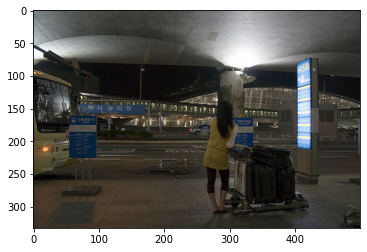

In [19]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
show_image(idx=44, train=True)

In [20]:
image_model = VGG16(include_top=True, weights='imagenet')

In [21]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We will use the output of the layer prior to the final classification-layer which is named fc2. This is a fully-connected (or dense) layer

In [22]:
transfer_layer = image_model.get_layer('fc2')

We call it the `transfer-layer` because we will transfer its output to another model that creates the image captions.

To do this, first we need to create a new model which has the same input as the original VGG16 model but outputs the transfer-values from the fc2 layer.

In [23]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

The model expects input images to be of this size:

In [24]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

For each input image, the new model will output a vector of transfer-values with this length:

In [25]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

## Processing images
We now make functions for processing all images in our data-set using the pre-trained image-model and saving the transfer-values in a cache-file so they can be reloaded quickly.

We effectively create a new data-set of the transfer-values. This is because it takes a long time to process an image in the VGG16 model. We will not be changing all the parameters of the VGG16 model, so every time it processes an image, it gives the exact same result. We need the transfer-values to train the image-captioning model for many epochs, so we save ourselves a lot of time by calculating the transfer-values once and saving them in a cache-file.

This is a helper-function for printing progress.

In [26]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

This is the function for processing the given files using the pretrained VGG16-model and returning their transfer-values.

In [27]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on a GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

Let's cache the results of a generic function for reuse:

In [28]:
def cache(cache_path, fn, *args, **kwargs):
    """
    Cache-wrapper for a function or class. If the cache-file exists
    then the data is reloaded and returned, otherwise the function
    is called and the result is saved to cache. The fn-argument can
    also be a class instead, in which case an object-instance is
    created and saved to the cache-file.
    :param cache_path:
        File-path for the cache-file.
    :param fn:
        Function or class to be called.
    :param args:
        Arguments to the function or class-init.
    :param kwargs:
        Keyword arguments to the function or class-init.
    :return:
        The result of calling the function or creating the object-instance.
    """

    # If the cache-file exists.
    if os.path.exists(cache_path):
        # Load the cached data from the file.
        with open(cache_path, mode='rb') as file:
            obj = pickle.load(file)

        print("- Data loaded from cache-file: " + cache_path)
    else:
        # The cache-file does not exist.

        # Call the function / class-init with the supplied arguments.
        obj = fn(*args, **kwargs)

        # Save the data to a cache-file.
        with open(cache_path, mode='wb') as file:
            pickle.dump(obj, file)

        print("- Data saved to cache-file: " + cache_path)

    return obj

In [29]:
def convert_numpy2pickle(in_path, out_path):
    """
    Convert a numpy-file to pickle-file.
    The first version of the cache-function used numpy for saving the data.
    Instead of re-calculating all the data, you can just convert the
    cache-file using this function.
    :param in_path:
        Input file in numpy-format written using numpy.save().
    :param out_path:
        Output file written as a pickle-file.
    :return:
        Nothing.
    """

    # Load the data using numpy.
    data = np.load(in_path)

    # Save the data using pickle.
    with open(out_path, mode='wb') as file:
        pickle.dump(data, file)

In [30]:
# This is the function that will only get called if the result
# is not already saved in the cache-file. This would normally
# be a function that takes a long time to compute
def expensive_function(a, b):
    return a * b

print('Computing expensive_function() ...')

# Either load the result from a cache-file if it already exists,
# otherwise calculate expensive_function(a=123, b=456) and
# save the result to the cache-file for next time.
result = cache(cache_path=os.path.join('data', 'cache_expensive_function.pkl'),
               fn=expensive_function, a=123, b=456)

print('result =', result)

Computing expensive_function() ...
- Data loaded from cache-file: data/cache_expensive_function.pkl
result = 56088


In [31]:
# We want to cache an object-instance of this class.
# The motivation is to do an expensive computation only once,
# or if we need to persist the data for some other reason.
class ExpensiveClass:
    def __init__(self, c, d):
        self.c = c
        self.d = d
        self.result = c * d

    def print_result(self):
        print('c =', self.c)
        print('d =', self.d)
        print('result = c * d =', self.result)

print('Creating object from ExpensiveClass() ...')

# Either load the object from a cache-file if it already exists,
# otherwise make an object-instance ExpensiveClass(c=123, d=456)
# and save the object to the cache-file for the next time.
obj = cache(cache_path=os.path.join('data', 'cache_ExpensiveClass.pkl'),
            fn=ExpensiveClass, c=123, d=456)

obj.print_result()

Creating object from ExpensiveClass() ...
- Data loaded from cache-file: data/cache_ExpensiveClass.pkl
c = 123
d = 456
result = c * d = 56088


### Complete model

Not restricting the number of files to process, and then we are going up to include *all of* coco, which consists of about 118287 images.

In [32]:
len(train_filenames), len(val_filenames)

(118287, 5000)

This is a helper-function for processing all images in the training-set. This saves the transfer-values in a cache-file for fast reloading.

In [33]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(train_filenames)))

    cache_path = os.path.join(train_images_path, "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    # use this for coco
    transfer_values = cache(cache_path=cache_path,
                        fn=process_images,
                        data_dir=train_images_path,
                        filenames=train_filenames)

    return transfer_values

In [34]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(val_filenames)))

    # Path for the cache-file.
    cache_path = os.path.join(val_images_path, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=val_images_path,
                            filenames=val_filenames)

    return transfer_values

In [35]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Data loaded from cache-file: train2017/transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)
CPU times: user 1.44 ms, sys: 321 ms, total: 323 ms
Wall time: 432 ms


In [36]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Data loaded from cache-file: val2017/transfer_values_val.pkl
dtype: float16
shape: (5000, 4096)
CPU times: user 700 µs, sys: 13.9 ms, total: 14.6 ms
Wall time: 29.5 ms


## Tokenizing
We use our usual two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into integer-tokens. The second step is to convert integer-tokens into smaller vectors of floating-point numbers using a an embedding-layer. 

Before we can start processing the text, we first need to mark the beginning and end of each text-sequence with our start and end sentinels.

In [37]:
# use this if you have lists of captions
def mark_captions(captions_listlist):
   captions_marked = [['<start>' + caption + '<end>'
                       for caption in captions_list]
                       for captions_list in captions_listlist]
   
   return captions_marked


In [38]:
captions_train_marked = mark_captions(train_captions)
captions_train_marked[0]

['<start>Closeup of bins of food that include broccoli and bread.<end>',
 '<start>A meal is presented in brightly colored plastic trays.<end>',
 '<start>there are containers filled with different kinds of foods<end>',
 '<start>Colorful dishes holding meat, vegetables, fruit, and bread.<end>',
 '<start>A bunch of trays that have different food.<end>']

In [39]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

captions_train_flat = flatten(captions_train_marked)
captions_train_flat[0:10]

['<start>Closeup of bins of food that include broccoli and bread.<end>',
 '<start>A meal is presented in brightly colored plastic trays.<end>',
 '<start>there are containers filled with different kinds of foods<end>',
 '<start>Colorful dishes holding meat, vegetables, fruit, and bread.<end>',
 '<start>A bunch of trays that have different food.<end>',
 '<start>A giraffe eating food from the top of the tree.<end>',
 '<start>A giraffe standing up nearby a tree <end>',
 '<start>A giraffe mother with its baby in the forest.<end>',
 '<start>Two giraffes standing in a tree filled area.<end>',
 '<start>A giraffe standing next to a forest filled with trees.<end>']

We set the maximum number of words in our vocabulary. We will only use e.g. the 10,000 most frequent words in the captions from the training-data.

In [40]:
num_words = 10000

In [41]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

Let's create a tokenizer using all the captions in the training-data. Note that you will need to use the flattened list version to create the tokenizer because it cannot take a list-of-lists.

In [42]:
len(captions_train_flat)

591753

In [43]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat, num_words=num_words)

CPU times: user 7.5 s, sys: 0 ns, total: 7.5 s
Wall time: 7.5 s


In [44]:

token_start = tokenizer.word_index['start']
token_start

3

In [45]:

token_end = tokenizer.word_index['end']
token_end

2

Let's convert all the captions from the training-set to sequences of integer-tokens. We end up with a list-of-lists.

In [46]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 7.62 s, sys: 124 ms, total: 7.75 s
Wall time: 7.74 s


In [47]:
captions_train_flat[4]

'<start>A bunch of trays that have different food.<end>'

In [48]:
tokens_train[0][4]

[3, 1, 170, 5, 1109, 26, 446, 190, 61, 2]

In [49]:
tokens_train[0][1]

[3, 1, 429, 10, 3308, 7, 1024, 390, 501, 1109, 2]

## Data Generator
With coco, each image in the training-set has at least 5 captions describing the contents of the image. 

So our neural network will be trained with batches of transfer-values for the images, and multiple sequences of integer-tokens for the captions. 

If we want matching numpy arrays for the training-set, we would either have to use a single caption for each image and ignore the rest, or we would have to repeat the image transfer-values for each of the captions.

A better solution for coco is to create a custom data-generator for Keras that will create a batch of data with randomly selected transfer-values and token-sequences.

For example, this helper-function returns a list of random token-sequences for the images with the given indices in the training-set.

In [50]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

Now we're ready to create random batches of training-data, using a Keras generator, to train our neural network with.

Note that we select the data completely randomly for each batch, corresponding to sampling of the training-set **with
replacement**. 

This means it is possible to sample the same data multiple times within a single epoch - and it is also possible that some data is not sampled at all within an epoch. However, the data is unique within a single batch.

We select a batch of images and captions, we pad the sequences to a fixed length, the decoder's input data and output data are shifted by one time-step, and we employ dictionaries for the encoder and decoder vocabularies.


In [51]:
len(train_filenames)

118287

In [52]:
# num_images_train = 1000
num_images_train = len(train_filenames)

In [53]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.

        # use this for coco
        tokens = get_random_caption_tokens(idx)
        # use this for flickr8k
#         tokens = get_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

Now we can set the batch-size to be used during training. 

In [54]:
batch_size = 64

Create an instance of our data generator:

In [55]:
generator = batch_generator(batch_size=batch_size)

In [56]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [57]:
batch_x['transfer_values_input'][0]

array([0.    , 0.    , 1.533 , ..., 0.    , 0.    , 0.6494], dtype=float16)

Example of the transfer-values for the first image in the batch.

In [58]:
batch_x['decoder_input'][0]

array([   3,    1, 5948, 2944,  179,   16,    6,  296, 1119,    2,    0,
          0,    0,    0,    0,    0], dtype=int32)

This is the token-sequence for the output of the decoder. Note how it is the same as the sequence above, except it is shifted one time-step.

In [59]:
batch_y['decoder_output'][0]

array([   1, 5948, 2944,  179,   16,    6,  296, 1119,    2,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

# Steps Per Epoch
One **epoch** is a complete processing of the training-set. 

We would like to process each image and caption pair only once per epoch. However, because each batch is chosen completely at random in the above batch-generator, it is possible that an image occurs in multiple batches within a single epoch, and it is possible that some images may not occur in any batch at all within a single epoch.

Nevertheless, we still use the concept of an **epoch** to measure approximately how many iterations of the training-data we have processed. But the data-generator will generate batches for eternity, so we need to manually calculate the approximate number of batches required per epoch.

This would be the number of captions for each image in the training-set, which would only be applicable for coco:

In [60]:

num_captions_train = [len(captions) for captions in train_captions]
print(num_captions_train)


[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

And for coco, this would be the total number of captions in the training-set:

In [61]:
total_num_captions_train = np.sum(num_captions_train)

For coco, this would be the approximate number of batches required per epoch, if we wanted to process each caption and image pair once per epoch.

In [62]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

9246

# Create the Recurrent Neural Network¶
We are now ready to create our Recurrent Neural Network (RNN) that will be trained to map the vectors with transfer-values from the image-recognition model into sequences of integer-tokens that can be translated into text. 

We call this neural network the **decoder** as it is almost identical to the decoder when doing Machine Translation.

Note that as usual we are using the functional model from Keras to build the neural network, because it allows more flexibility in how the neural network can be connected, in case you want to experiment and connect the image-model directly to the decoder 

This means we have split the network construction into two parts: (1) Creation of all the layers that are not yet connected, and (2) a function that connects all these layers.

The decoder consists of 3 GRU layers whose internal state-sizes are:

In [63]:
state_size = 512

The embedding-layer converts integer-tokens into vectors of this length:

In [64]:
embedding_size = 128

This inputs transfer-values to the decoder:

In [65]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

We want to use the transfer-values to initialize the internal states of the GRU units. 

This informs the GRU units of the contents of the images. The transfer-values are vectors of length 4096 but the size of the internal states of the GRU units are only 512!

So we need to use a fully-connected layer to map the vectors from 4096 to 512 elements.

Note that we use a `tanh` activation function to limit the output of the mapping between -1 and 1, otherwise this does not seem to work.

In [66]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

This is the input for token-sequences to the decoder. As usual, using `None` in the shape means that the token-sequences can have arbitrary lengths.

In [67]:
decoder_input = Input(shape=(None, ), name='decoder_input')

This is the keras embedding-layer which converts sequences of **integer**-tokens to vectors which are sequences of **floats**.

This emebdding trains together with the rest of the network (i.e. we do not load any pretrained embeddin. The only pretrained part of our two networks is VGG-16).

In [68]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

Ok, let's create the 3 GRU layers of the decoder. 

Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence.

In [69]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

The GRU layers output a tensor with shape [batch_size, sequence_length, state_size], where each **word** is encoded as a vector of length `state_size`. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

One way of doing this is to convert the GRU output to a one-hot encoded array. It works but it is somewhat wasteful, because for a vocabulary of e.g. 10,000 words we need a vector with 10,000 elements, so we can select the index of the highest element to be the integer-token.

In [70]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

## Connect and Create the Training Model

The decoder is built using the functional API of Keras, which allows flexibility in connecting the layers e.g. to have multiple inputs. This is useful for example if you want to connect the image-model directly with the decoder instead of using pre-calculated transfer-values. In our past notebooks, we did it with classes and class constructors. 

Here, we will do it with just a function call. This function connects all the layers of the decoder to some input of transfer-values:

In [71]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

Let's connect and create the model used for training. 

Our model takes as input transfer-values, and sequences of integer-tokens. It outputs sequences of one-hot encoded arrays that can subsequently be converted into integer-tokens.

In [72]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

## Model compile
The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

But our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 10000 elements so it would be wasteful to convert the entire data-set to one-hot encoded arrays. We could do this conversion from integers to one-hot arrays in `batch_generator()` above.

A better way is to use a **sparse cross-entropy** loss-function, which does the conversion internally from integers to one-hot encoded arrays.

We will use the `RMSprop` optimizer, but yu should plan on using the `Adam` optimizer for coco. Note that Adam is known to diverge in some experiments with Recurrent Neural Networks.

In [73]:
decoder_model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-3),
                      loss='sparse_categorical_crossentropy')

## Checkpointing

During training we want to save checkpoints and we'll log progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [74]:

path_checkpoint = 'checkpoints/'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

This is the callback for writing the TensorBoard log during training (we won't do this):

In [75]:

callback_tensorboard = TensorBoard(log_dir='logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [76]:
#callbacks = [callback_checkpoint, callback_tensorboard]
callbacks = [callback_checkpoint]

## Loading Checkpoint
This is how you can reload the last saved checkpoint so you don't have to train the model every time you want to use it. Will give exception on the initial run.

In [77]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [78]:
decoder_model

Whew! We are now ready to train!

## Train the Model
We will train the decoder so it can map transfer-values from the image-model over to sequences of integer-tokens for the captions of the images.

Note that if we didn't use pre-computed transfer-values then each epoch would take 4 times as long to run, because all the images would have to be processed by the VGG16 model as well.

Let's start with 5 epochs!

In [78]:
# %%time
# decoder_model.fit(x=generator,
#                   steps_per_epoch=steps_per_epoch,
#                   epochs=5,
#                   callbacks=callbacks)

Epoch 1/5
9246/9246 [==============================] - ETA: 0s - loss: 1.8429
Epoch 1: saving model to checkpoints/
9246/9246 [==============================] - 2797s 302ms/step - loss: 1.8429
Epoch 2/5
9246/9246 [==============================] - ETA: 0s - loss: 1.7073
Epoch 2: saving model to checkpoints/
9246/9246 [==============================] - 2765s 299ms/step - loss: 1.7073
Epoch 3/5
9246/9246 [==============================] - ETA: 0s - loss: 1.6873
Epoch 3: saving model to checkpoints/
9246/9246 [==============================] - 2752s 298ms/step - loss: 1.6873
Epoch 4/5
9246/9246 [==============================] - ETA: 0s - loss: 1.6735
Epoch 4: saving model to checkpoints/
9246/9246 [==============================] - 2748s 297ms/step - loss: 1.6735
Epoch 5/5
9246/9246 [==============================] - ETA: 0s - loss: 1.6749
Epoch 5: saving model to checkpoints/
9246/9246 [==============================] - 2748s 297ms/step - loss: 1.6749
CPU times: user 5d 5h 19min 53s, sy

In [79]:
# %%time
# decoder_model.fit(x=generator,
#                   steps_per_epoch=steps_per_epoch,
#                   epochs=1,
#                   callbacks=callbacks)

9246/9246 [==============================] - ETA: 0s - loss: 1.6693
Epoch 1: saving model to checkpoints/
9246/9246 [==============================] - 2759s 298ms/step - loss: 1.6693
CPU times: user 1d 1h 31min 29s, sys: 9h 38min 48s, total: 1d 11h 10min 17s
Wall time: 45min 59s


In [80]:
# %%time
# decoder_model.fit(x=generator,
#                   steps_per_epoch=steps_per_epoch,
#                   epochs=1,
#                   callbacks=callbacks)

9246/9246 [==============================] - ETA: 0s - loss: 1.6651
Epoch 1: saving model to checkpoints/
9246/9246 [==============================] - 2768s 299ms/step - loss: 1.6651
CPU times: user 1d 1h 32min 40s, sys: 9h 46min 39s, total: 1d 11h 19min 20s
Wall time: 46min 8s


In [82]:
# %%time
# decoder_model.fit(x=generator,
#                   steps_per_epoch=steps_per_epoch,
#                   epochs=1,
#                   callbacks=callbacks)

9246/9246 [==============================] - ETA: 0s - loss: 1.6586
Epoch 1: saving model to checkpoints/
9246/9246 [==============================] - 2776s 300ms/step - loss: 1.6586
CPU times: user 1d 1h 39min 38s, sys: 9h 41min 35s, total: 1d 11h 21min 13s
Wall time: 46min 16s


In [83]:
# %%time
# decoder_model.fit(x=generator,
#                   steps_per_epoch=steps_per_epoch,
#                   epochs=1,
#                   callbacks=callbacks)

9246/9246 [==============================] - ETA: 0s - loss: 1.6554
Epoch 1: saving model to checkpoints/
9246/9246 [==============================] - 2772s 300ms/step - loss: 1.6554
CPU times: user 1d 1h 41min 59s, sys: 9h 31min 21s, total: 1d 11h 13min 20s
Wall time: 46min 12s


In [80]:
# %%time
# decoder_model.fit(x=generator,
#                   steps_per_epoch=steps_per_epoch,
#                   epochs=10,
#                   callbacks=callbacks)

Epoch 1/10
9246/9246 [==============================] - ETA: 0s - loss: 1.6561
Epoch 1: saving model to checkpoints/
9246/9246 [==============================] - 2624s 284ms/step - loss: 1.6561
Epoch 2/10
9246/9246 [==============================] - ETA: 0s - loss: 1.6576
Epoch 2: saving model to checkpoints/
9246/9246 [==============================] - 2631s 285ms/step - loss: 1.6576
Epoch 3/10
9246/9246 [==============================] - ETA: 0s - loss: 1.6656
Epoch 3: saving model to checkpoints/
9246/9246 [==============================] - 2675s 289ms/step - loss: 1.6656
Epoch 4/10
9246/9246 [==============================] - ETA: 0s - loss: 1.6671
Epoch 4: saving model to checkpoints/
9246/9246 [==============================] - 2629s 284ms/step - loss: 1.6671
Epoch 5/10
9246/9246 [==============================] - ETA: 0s - loss: 1.6659
Epoch 5: saving model to checkpoints/
9246/9246 [==============================] - 2715s 294ms/step - loss: 1.6659
Epoch 6/10
9246/9246 [========

## Inference
Let's load an image and translate it to a caption using our trained model.

In [79]:
def translate(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

1/1 [==============================] - 0s 39ms/step


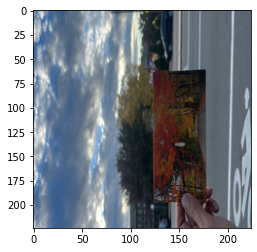

Predicted caption:
 a man riding a skateboard down a street end

1/1 [==============================] - 0s 38ms/step


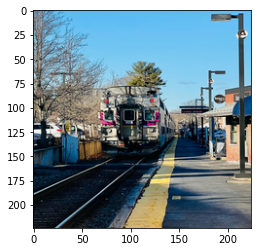

Predicted caption:
 a train is going down the tracks in a city end

1/1 [==============================] - 0s 37ms/step


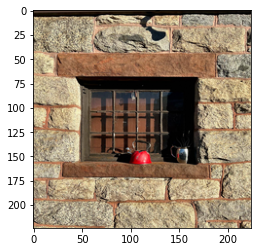

Predicted caption:
 a zebra standing in a grassy field with a tree in the background end

1/1 [==============================] - 0s 39ms/step


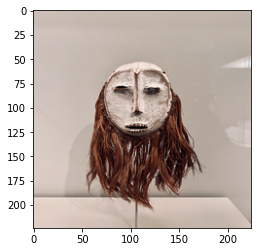

Predicted caption:
 a cat is sitting on a toilet in a bathroom end

1/1 [==============================] - 0s 38ms/step


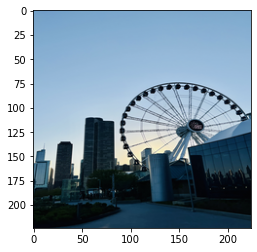

Predicted caption:
 a large clock tower with a large clock on it end

1/1 [==============================] - 0s 43ms/step


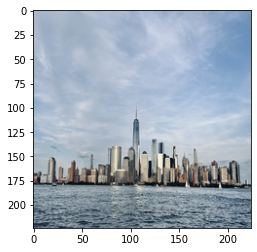

Predicted caption:
 a group of people flying kites on a sunny day end

1/1 [==============================] - 0s 42ms/step


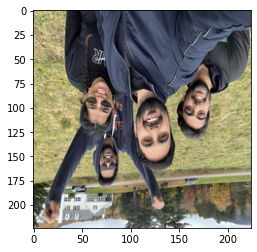

Predicted caption:
 a man riding a skateboard down a street end

1/1 [==============================] - 0s 36ms/step


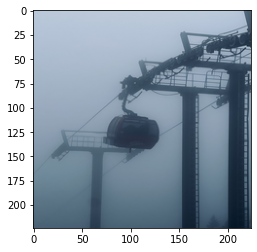

Predicted caption:
 a large white and blue train traveling down a track end

1/1 [==============================] - 0s 37ms/step


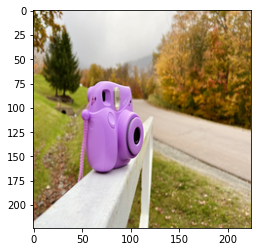

Predicted caption:
 a train traveling down a track in a forest end

1/1 [==============================] - 0s 39ms/step


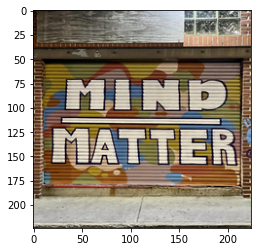

Predicted caption:
 a large clock tower with a large clock on top end



In [80]:
def process_folder(folder_path):
    # List all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            # Translate the image
            translate(file_path, max_tokens=30)

# Example usage
folder_path = 'test'
process_folder(folder_path)


## Conclusion
Our model translated images with a pre-trained image-model (VGG16), by generating a **thought-vector** of what the image contained, and then training a 3-layer sandwich of GRUs to map this thought-vector to a sequence of words.

This model does not have a human-like understanding of what the images contain. If it sees an image of a giraffe and correctly produces a caption stating that, it doesn't mean that the model has a deep understanding of what a giraffe is.

The model is merely a clever way of mapping pixels in an image to a vector of floating-point numbers that summarize the contents of the image, and then maps these numbers to a sequence of integers-tokens representing words. So the model is  just a very advanced function approximator.

>**Note**: ML is just statistics, not human-like intelligence, as some may like you to believe.


